In [ ]:
#default_exp discrete


# Utilities for Discrete Inference

This module provides utilities to work with discrete keys and the like for the first two chapters in the book.


In [ ]:
# export
import gtsam

from typing import List, Tuple, Callable, Dict


## DiscretePrior

DiscretePrior is now built into GTSAM:

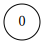

In [ ]:
C = 0, 5  # A key is an identifier and a cardinality
prior = gtsam.DiscretePrior(C, "25/20/30/20/5")
assert not prior.empty()

from gtbook.display import show
# TODO: this does not support formatting yet
show(prior)

In [ ]:
prior_probability_for_3 = prior(3)
assert prior_probability_for_3 == 0.2

## Variables

We would like to make it easier for people to create discrete variables, with a meaningful name, and meaningful strings associated with discrete values. Below is it possible design:

In [ ]:
# export

DiscreteKey = Tuple[int, int]


class Variables:
    """A problem domain for discrete variables."""

    BINARY = ["false", "true"]

    def __init__(self):
        self._variables = {}

    def discrete(self, name: str, domain: List[str]) -> DiscreteKey:
        """Create a variable with given name and discrete domain of named values.

        Args:
            name (str): name of the variable.
            domain (List[str]): names for the different values.

        Returns:
            key: DiscreteKey, i.e., (gtsam.Key, cardinality)
        """
        discreteKey = len(self._variables), len(domain)
        self._variables[discreteKey[0]] = name, domain
        return discreteKey

    def binary(self, name: str) -> DiscreteKey:
        """Create a binary variable with given name.

        Args:
            name (str): name of the variable.

        Returns:
            key: DiscreteKey, i.e., (gtsam.Key, cardinality)
        """
        return self.discrete(name, self.BINARY)

    def name(self, discreteKey: DiscreteKey) -> str:
        """Return name of variable with given discreteKey.

        Args:
            discreteKey (DiscreteKey): (gtsam.Key, cardinality)

        Returns:
            str: name of the variable.
        """
        return self._variables[discreteKey[0]][0]

    def domain(self, discreteKey: DiscreteKey):
        """Return domain of variable with given discreteKey.

        Args:
            discreteKey (DiscreteKey): (gtsam.Key, cardinality)

        Returns:
            str: domain of the variable.
        """
        return self._variables[discreteKey[0]][1]

    def keyFormatter(self) -> Callable:
        """Return a lambda that can be used as KeyFormatter in GTSAM"""
        return lambda key: self._variables[key][0]

    def names(self) -> Dict[int, List[str]]:
        """Return a names dictionary that is used by GTSAM markdown methods"""
        return {key: domain for (key, (name, domain)) in self._variables.items()}

    def assignment(self, map: Dict[DiscreteKey, str]) -> gtsam.DiscreteValues:
        """Create a GTSAM assignment of keys to values.

        Args:
            map (Dict[DiscreteKey, str]): map from discrete keys to values.

        Returns:
            gtsam.DiscreteValues: the GTSAM equivalent.
        """
        values = gtsam.DiscreteValues()
        for discreteKey, value in map.items():
            domain = self.domain(discreteKey)
            assert value in domain, f"Specified value not found in domain of {discreteKey}"
            values[discreteKey[0]] = domain.index(value)
        return values

    def values_markdown(self, assignment: gtsam.DiscreteValues) -> str:
        """Render a DiscreteValues instance as markdown.

        Args:
            assignment (gtsam.DiscreteValues): the values to render.

        Returns:
            str: a markdown string.
        """
        converted = {self._variables[key][0]: self._variables[key][1][value] for (
            key, value) in assignment.items()}
        ss = "|Variable|value|\n|:-:|:-:|\n"
        for key, value in assignment.items():
            name, domain = self._variables[key]
            ss += f"|{name}|{domain[value]}|\n"
        return ss


Here is an example:

In [ ]:
variables = Variables()
categories = ["cardboard", "paper", "can", "scrap metal", "bottle"]
Category = variables.discrete("Category", categories)

assert variables.name(Category) == "Category"
assert variables.domain(Category) == categories

Now it can provide a key formatter for us:

In [ ]:
keyFormatter = variables.keyFormatter()
assert keyFormatter(Category[0]) == "Category"

We can also create a names dictionary for the choices made in teh decision tree:

In [ ]:
names = variables.names()
assert isinstance(names, dict)
assert len(names) == 1
assert names == {0: ['cardboard', 'paper', 'can', 'scrap metal', 'bottle']}

Binary variables are supported as a special case:

In [ ]:
Conductivity = variables.binary("Conductivity")
assert variables.domain(Conductivity) == ["false", "true"]

Providing the domains to the `Variables` data structure also makes it easy to create 

In [ ]:
assignment = variables.assignment({Category:"can"})
assert isinstance(assignment, gtsam.DiscreteValues)
assert assignment[C[0]] == categories.index("can")

We also create a markdown renderer for `DiscreteValues`, awaiting the ability of pybind11 to wrap classes ingereited from STL containers:

In [ ]:
assert variables.values_markdown(assignment) == '|Variable|value|\n|:-:|:-:|\n|Category|can|\n'